# Simulating an M/M/1 Queueing System with Python and SimPy

## Author: Fernando A. Acosta-Perez

### Overview
This notebook demonstrates the simulation of an M/M/1 queueing system using the SimPy library in Python. The simulation evaluates key metrics such as average waiting time and average queue size, providing insights into the system's performance under specific arrival and service rates.

---


## Import libraries

In [ ]:
import simpy
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Build Simulation

In [202]:
class MonitoredResource(simpy.Resource):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.data = []  # To store queue length and timestamp

    def request(self, *args, **kwargs):
        self.data.append((self._env.now, len(self.queue)))  # Log queue length at request
        return super().request(*args, **kwargs)

    def release(self, *args, **kwargs):
        self.data.append((self._env.now, len(self.queue)))  # Log queue length at release
        return super().release(*args, **kwargs)

# Define the Customer Entity Process
def customer_process(env, name, server, arrival_time, service_rate, wait_times):
    """
    Simulates the behavior of a customer entity:
    - Arrives and waits for the server.
    - Receives service and leaves the system.
    Args:
        env (Simpy object): Simulation environment.
        name (String): Name of the customer starting the process. 
        server (MonitoredResource): The capacitated Simpy resource object.
        arrival_time (float): Arrival time of the customer. 
        service_rate (float): Service rate for generating random service times.
        wait_times (list): A list to store waiting times for analysis.
    """
    print(f"{name} arrives at {env.now:.2f}")
    
    with server.request() as request:
        # Wait for server availability
        yield request

        # Calculate waiting time
        wait_time = env.now - arrival_time
        wait_times.append(wait_time)
        print(f"{name} starts service at {env.now:.2f} after waiting {wait_time:.2f}")
        
        # Simulate service time
        service_time = random.expovariate(service_rate)
        yield env.timeout(service_time)
        print(f"{name} leaves at {env.now:.2f}")

# Define the Customer Arrival Process
def customer_arrivals(env, server, interarrival_rate, service_rate, wait_times):
    """
    Simulates the arrival of customer entities:
    - Customers arrive based on an exponential interarrival time.
    - Each customer starts a 'customer_process' process.
    
    Args:
        env (Simpy object): The Simpy simulation environment.
        server (MonitoredResource): The capacitated Simpy resource object. 
        interarrival_rate (float): The arrival rate used to generate random arrivals. 
        service_rate (float): Service rate for generating random service times.
        wait_times (list): A list to store waiting times for analysis.
    """
    customer_count = 0
    while True:
        # Time until the next customer arrives
        interarrival_time = random.expovariate(interarrival_rate)
        yield env.timeout(interarrival_time)  # Wait until the next arrival

        # Once the customer arrives, it flows through the system
        customer_count += 1
        env.process(customer_process(env, f"Customer {customer_count}", server, env.now, service_rate, wait_times))

# Simulation Setup and Execution
def run_simulation(simulation_time, interarrival_rate, service_rate, num_servers):
    """
    Sets up and runs the M/M/1 queue simulation:
    - Initializes environment, resources, and processes.
    - Tracks performance metrics.
    Args:
        simulation_time (float): Total time to run the simulation.
        interarrival_rate (float): Customers interarrival rate.
        service_rate (float): Service rate for the Simpy capacitated resource.
        num_servers (float): Total number of servers in the Simpy resource.
    """
    # Initialize Simpy simulation environment
    env = simpy.Environment()

    # Create monitored server (resource)
    server = MonitoredResource(env, capacity=num_servers)

    # Track waiting times
    wait_times = []

    # Start the customer arrival process
    env.process(customer_arrivals(env, server, interarrival_rate, service_rate, wait_times))

    # Run simulation
    env.run(until=simulation_time)
    
    # Log the final queue size
    final_queue_size = len(server.queue)
    server.data.append((simulation_time, final_queue_size))

    # Compute metrics
    avg_waiting_time = np.mean(wait_times) if wait_times else 0 # wait time
    queue_data = np.array(server.data) 
    event_times = queue_data[:, 0]
    rolled_event_times = np.roll(queue_data[:, 0], shift=1)
    event_times[0] = 0
    queue = queue_data[:, 1]
    avg_queue_size = np.sum(queue*(event_times - rolled_event_times))/simulation_time
        
    # Display metrics
    print(f"\nAverage waiting time (simulation): {avg_waiting_time:.2f} time units")
    print(f"Resource usage data (time, queue size): {avg_queue_size:.2F}")

    return wait_times, queue_data

## Execution

In [222]:
# Main Code Execution
if __name__ == "__main__":
    # Define simulation parameters
    SIMULATION_TIME = 24 * 365 # Total time to simulate
    INTERARRIVAL_RATE = 1      # Mean arrival rate (customers per time unit)
    SERVICE_RATE = 1.2         # Mean service rate (customers served per time unit)
    NUM_SERVERS = 1            # Number of servers (M/M/1)

    # Run the simulation
    wait_times, queue_sizes= run_simulation(SIMULATION_TIME, INTERARRIVAL_RATE, SERVICE_RATE, NUM_SERVERS)

Customer 1 arrives at 0.13
Customer 1 starts service at 0.13 after waiting 0.00
Customer 2 arrives at 1.44
Customer 1 leaves at 3.46
Customer 2 starts service at 3.46 after waiting 2.02
Customer 3 arrives at 5.01
Customer 4 arrives at 5.42
Customer 5 arrives at 6.67
Customer 2 leaves at 6.71
Customer 3 starts service at 6.71 after waiting 1.69
Customer 3 leaves at 6.82
Customer 4 starts service at 6.82 after waiting 1.40
Customer 6 arrives at 8.03
Customer 7 arrives at 9.05
Customer 4 leaves at 9.55
Customer 5 starts service at 9.55 after waiting 2.88
Customer 5 leaves at 10.73
Customer 6 starts service at 10.73 after waiting 2.70
Customer 8 arrives at 10.78
Customer 6 leaves at 12.07
Customer 7 starts service at 12.07 after waiting 3.02
Customer 9 arrives at 12.29
Customer 10 arrives at 12.51
Customer 7 leaves at 13.04
Customer 8 starts service at 13.04 after waiting 2.26
Customer 11 arrives at 13.27
Customer 12 arrives at 13.40
Customer 8 leaves at 13.52
Customer 9 starts service at 

## Data Analysis

In [216]:
plt.style.use('seaborn-v0_8-pastel')

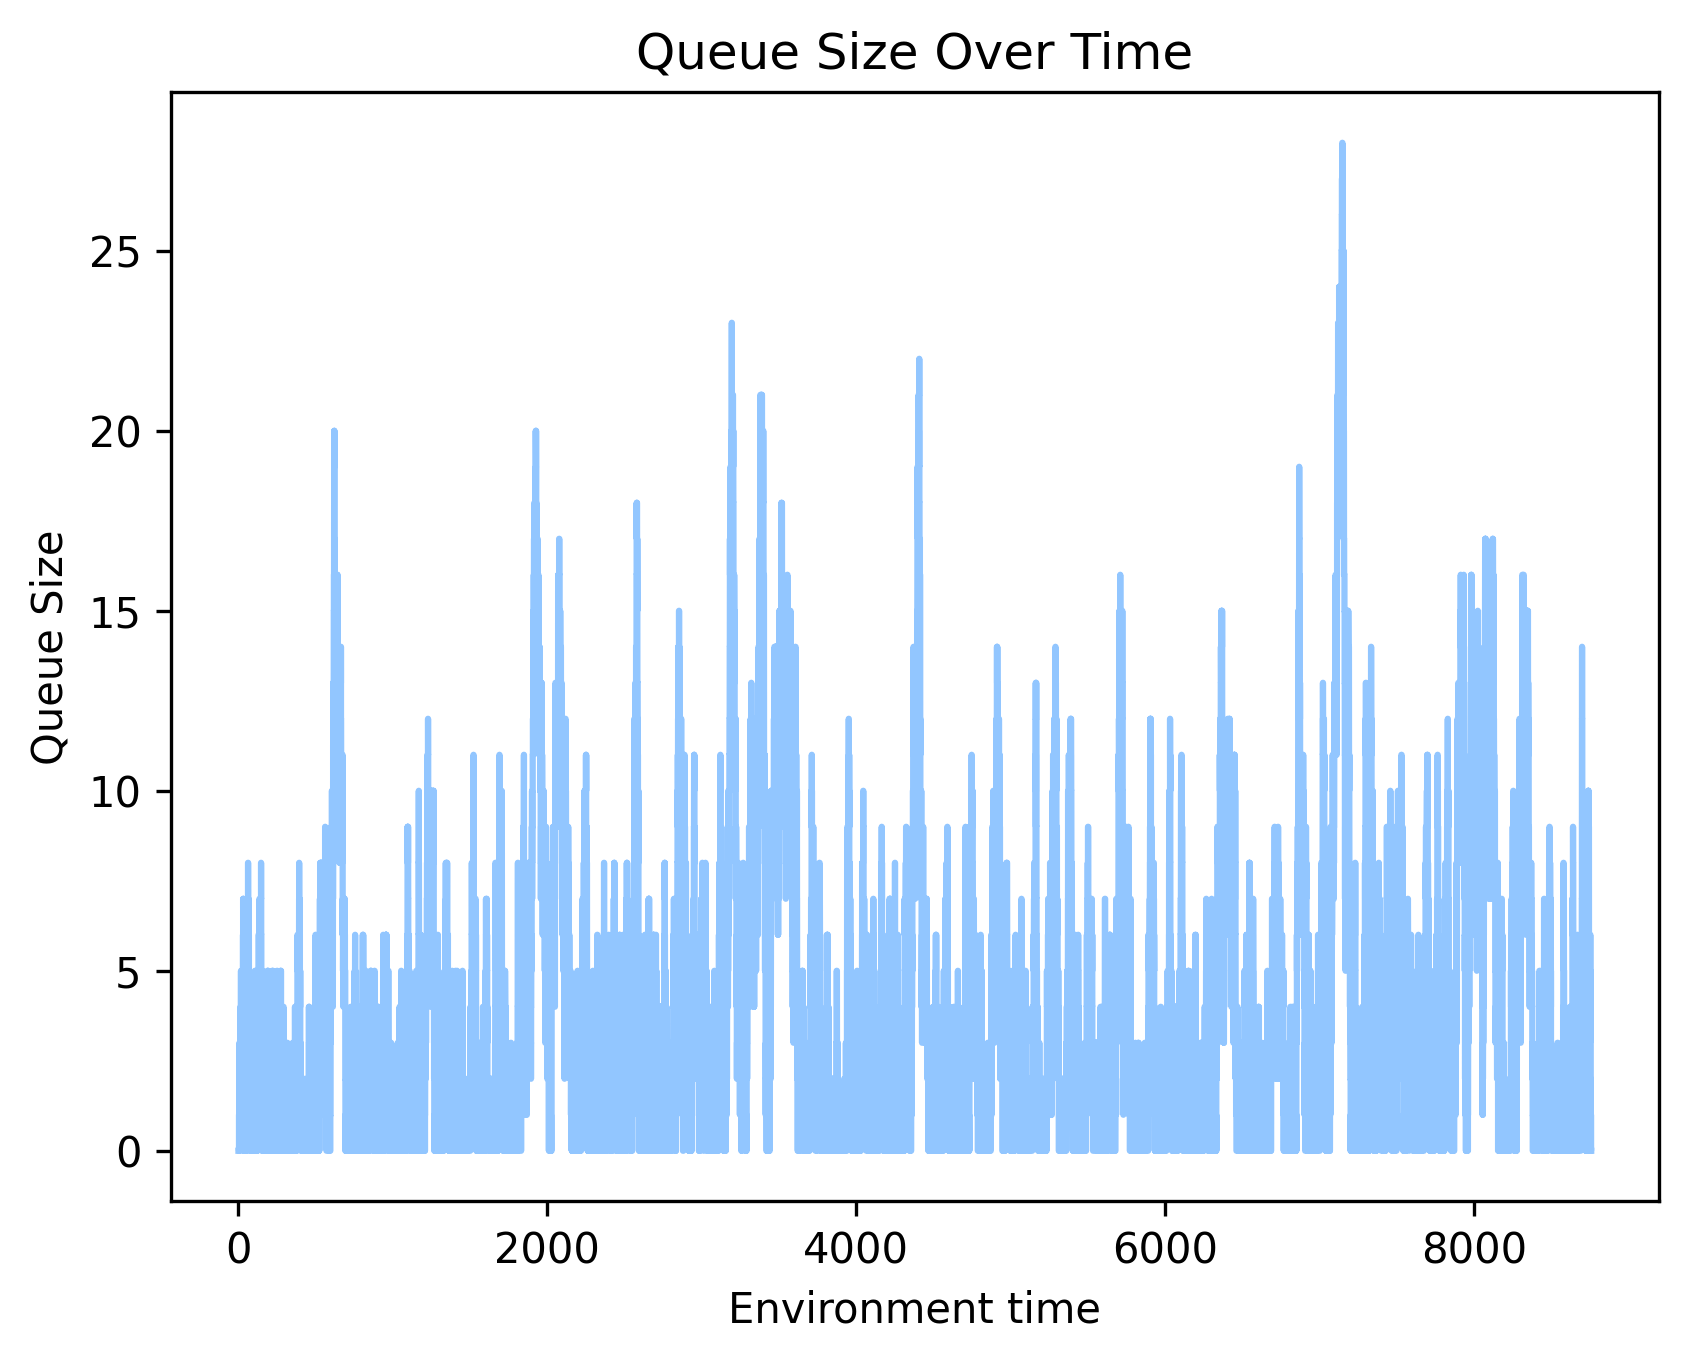

In [223]:
# Define data
data= np.array(queue_sizes)
env_time= data[:, 0]
queue= data[:, 1]

# Plot queue size as a step plot
plt.figure(dpi=300)
plt.step(env_time, queue, where='post')
plt.xlabel('Environment time')
plt.ylabel('Queue Size')
plt.title('Queue Size Over Time')
plt.show()
plt.close()


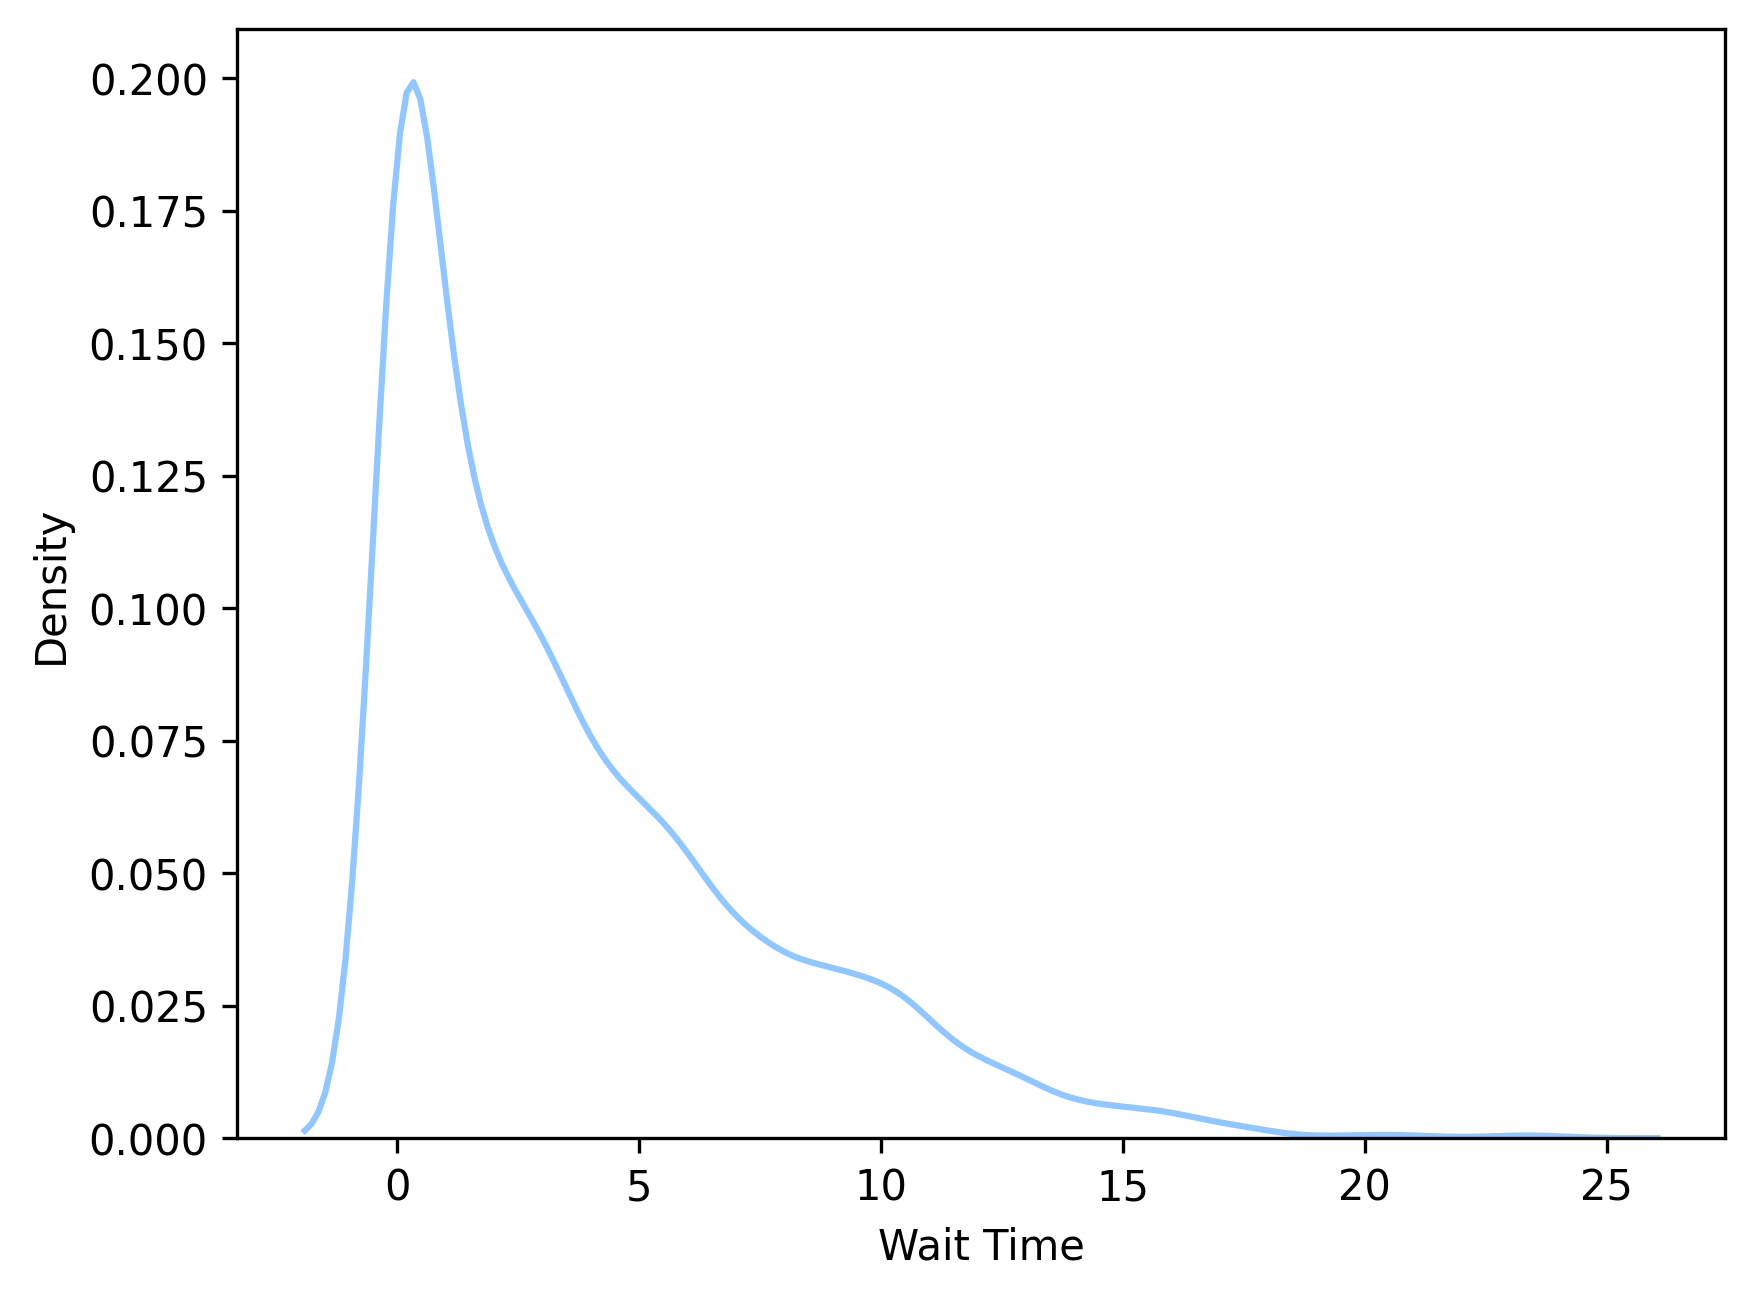

In [224]:
# Visualize waiting time
plt.figure(dpi=300)
sns.kdeplot(wait_times)
plt.xlabel('Wait Time')
plt.show()
plt.close()